## Common Bijectors

The choice of bijector functions is a fast changing area. I will thus only mention a few. You can of course use any bijective function or matrix, but these become inefficient at high-dimension due to the Jacobian calculation. One class of efficient bijectors are autoregressive bijectors. These have triangular Jacobians because each output dimension can only depend on the dimensions with a lower index. There are two variants: masked autoregressive flows (MAF){cite}`papamakarios2017masked` and inverse autoregressive flows (IAF) {cite}`kingma2016improved`. MAFs are efficient at training and computing probabilities, but are slow for sampling from $P(x)$. IAFs are slow at training and computing probabilities but efficient for sampling. Wavenets combine the advantages of both {cite}`kim2018flowavenet`. I'll mention one other common bijector which is not autoregressive: real non-volume preserving (RealNVPs) {cite}`dinh2016density`. RealNVPs are less expressive than IAFs/MAFs, meaning they have trouble replicating complex distributions, but are efficient at all three tasks: training, sampling, and computing probabilities. Another interesting variant is the Glow bijector,which is able to expand the rank of the normalizing flow, for example going from a matrix to an RGB image {cite}`das2019dimensionality`. What are the equations for all these bijectors? Most are variants of standard neural network layers but with special rules about which outputs depend on which inputs. 

### Z Distribution

Our Z distribution should always be as simple as possible. I'll create a 2D Gaussian with unit variance, no covariance, and centered at 0. I'll be using the tensorflow probability package for this example. The key new concept is that we organize our tensors that were *sampled* from a probability distribution in a specific way. We, by convention, make the first axes be the **sample** shape, the second axes be the **batch** shape, and the final axes be the **event** shape. The sample shape is the number of times we sampled from our distribution. It is a *shape* and not a single dimension because occasionally you'll want to organize your samples into some shape. The batch shape is a result of possibly multiple distributions batched together. For example, you might have 2 Gaussians, instead of a single 2D Gaussian. Finally, the event shape is the shape of a single sample from the distribution. This is overly complicated for our example, but you should be able to read information about the distribution now by understanding this nomenclature. You can find a tutorial on these [shapes here](https://www.tensorflow.org/probability/examples/Understanding_TensorFlow_Distributions_Shapes) and more tutorials on [tensorflow probability here](https://www.tensorflow.org/probability/examples/A_Tour_of_TensorFlow_Probability). 

In [1]:
import numpy as np
from scipy.stats import gaussian_kde
import matplotlib.pyplot as plt
import corner
import sklearn.datasets as datasets
import tensorflow as tf
import tensorflow_addons as tfa
import tensorflow_probability as tfp

tfd = tfp.distributions
tfb = tfp.bijectors

np.random.seed(0)
tf.random.set_seed(0)

2022-07-04 23:22:00.636182: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-07-04 23:22:00.636207: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


## Target data

(10000, 2) (10000,)


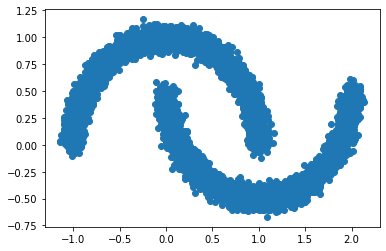

In [2]:
n_samples = 10000
n_dim = 2
data, _ = datasets.make_moons(n_samples, noise=.05)

print(data.shape, _.shape)

plt.scatter(*data.T);

## Normalizing flow

In [3]:
# n_layers = 3
# bijectors = []

# for i in range(n_layers):
#     bijectors.append(
#         tfb.MaskedAutoregressiveFlow(tfb.AutoregressiveNetwork(
#             params=n_dim,
#             hidden_units=[128, 128],
#             activation='relu',
#             #activation=tfa.activations.rrelu,
#             ))
#         )
#     bijectors.append(tfb.Permute([1, 0]))
    
# bijector = tfb.Chain(bijectors)
# trans_dist = tfd.TransformedDistribution(z_dist, bijector=bijector)

In [21]:
n_flows = 10
n_layers = 1
n_neurons = 1024

# distribution = tfd.Sample(
#     distribution=tfd.MultivariateNormalDiag(loc=[0]*n_dim),
#     )
distribution = tfd.MultivariateNormalDiag(loc=[0]*n_dim)

bijectors = []
for _ in range(n_flows):
    bijectors.append(
        tfb.MaskedAutoregressiveFlow(tfb.AutoregressiveNetwork(
            params=n_dim,
            hidden_units=[n_neurons]*n_layers,
            activation='relu',
            #activation=tfa.activations.rrelu,
            ))
        )
    bijectors.append(tfb.Permute([1,0]))
    
bijector = tfb.Chain(bijectors)

nf = tfd.TransformedDistribution(
    distribution=distribution,
    bijector=bijector,
    )

## Training

In [22]:
x = tf.keras.Input(shape=[n_dim], dtype=tf.float32)
log_prob = nf.log_prob(x)

model = tf.keras.Model(
    inputs=x,
    outputs=log_prob,
    )

model.compile(
    optimizer=tf.optimizers.Adam(learning_rate=1e-3),
    loss=lambda _, log_prob: -log_prob,
    )

In [23]:
epochs = 500
batch_size = 32
steps_per_epoch = n_samples // batch_size

result = model.fit(
    x=data, y=np.zeros(n_samples),
    epochs=epochs, 
    batch_size=batch_size,
    steps_per_epoch=steps_per_epoch,
    shuffle=True,
    verbose=True,
    )

Epoch 1/500
312/312 [==============================] - 7s 8ms/step - loss: 1.6409
Epoch 2/500
312/312 [==============================] - 2s 8ms/step - loss: 1.2134
Epoch 3/500
312/312 [==============================] - 2s 8ms/step - loss: 1.4872
Epoch 4/500
312/312 [==============================] - 3s 8ms/step - loss: 1.2993
Epoch 5/500
312/312 [==============================] - 2s 8ms/step - loss: 0.7622
Epoch 6/500
312/312 [==============================] - 3s 8ms/step - loss: 0.7096
Epoch 7/500
312/312 [==============================] - 3s 8ms/step - loss: 0.6800
Epoch 8/500
312/312 [==============================] - 3s 8ms/step - loss: 0.6275
Epoch 9/500
312/312 [==============================] - 3s 9ms/step - loss: 0.6175
Epoch 10/500
312/312 [==============================] - 3s 9ms/step - loss: 0.5712
Epoch 11/500
312/312 [==============================] - 3s 8ms/step - loss: 0.5269
Epoch 12/500
312/312 [==============================] - 2s 8ms/step - loss: 0.5430
Epoch 13/500


(0.0, 1.0)

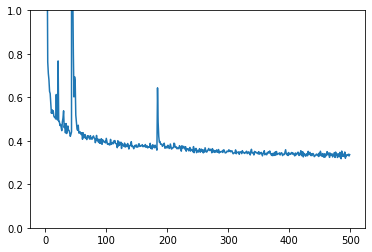

In [29]:
plt.plot(result.history['loss']);
plt.ylim(0, 1)

## Prediction

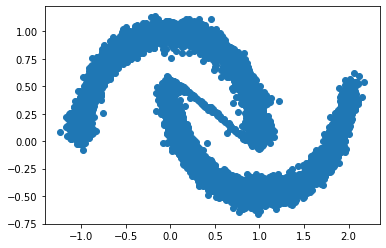

In [30]:
z_samples = nf.sample(n_samples)

plt.scatter(*z_samples.numpy().T);

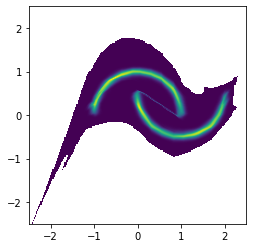

In [31]:
z_points = np.linspace(-2.5, 2.5, 200)
z1, z2 = np.meshgrid(z_points, z_points)
z_grid = np.concatenate(
    [z1.reshape(-1, 1), z2.reshape(-1, 1)], axis=1,
    )

probs = np.exp(nf.log_prob(z_grid))                      

plt.imshow(
    probs.reshape(z1.shape),
    aspect='equal',
    origin='lower',
    extent=[-2.5, 2.5, -2.5, 2.5],
    );

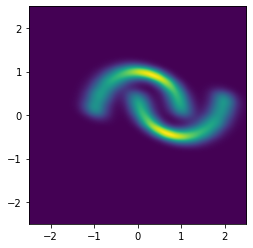

In [18]:
kde = gaussian_kde(data.T)(z_grid.T)

plt.imshow(
    kde.reshape(z1.shape),
    aspect='equal',
    origin='lower',
    extent=[-2.5, 2.5, -2.5, 2.5],
    );